# LAS File Bulk Processing Pipeline
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Petrophysics & Static Modeling

**Objective:** Ingest multiple LAS files with inconsistent naming conventions, clean the data, and normalize the mnemonics using `welly` and `lasio`.

**Workflow:**
1.  **Load Data:** Read generic `.las` files from a directory.
2.  **Quality Control (QC):** Inspect raw headers and curve names.
3.  **Define Aliases:** Create a dictionary mapping standard names to the variations found in the files.
4.  **Bulk Normalization:** Apply the alias map to rename curves across all wells.
5.  **Visualization:** Compare raw vs. processed data.
6.  **Export:** Create a clean DataFrame for downstream machine learning tasks.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
from welly import Project, Well, Curve

# Configuration for prettier plots
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### 1. Loading the Project
We use `welly.Project` to handle multiple wells simultaneously. Unlike standard `lasio` loops, `welly` treats the folder as a cohesive project, allowing for batch operations.

In [4]:
# Define path to data
data_path = '../data/*.las'

# Load all files matching the pattern
project = Project.from_las(data_path)

print(f"Successfully loaded {len(project)} wells.")
display(project)



10it [00:00, 67.28it/s]

Successfully loaded 10 wells.


Index,UWI,Data,Curves
0,,3 curves,"GR, NEUT, DENS"
1,,3 curves,"G.R., NPHI, RHOB"
2,,3 curves,"GR, NPHI, RHOB"
3,,3 curves,"G, NPHI_V1, RHOB_FINAL"
4,,3 curves,"GAMMA, NEUT, DENS"
5,,3 curves,"GR, NPHI, RHOB"
6,,3 curves,"GR, NPHI, RHOB"
7,,3 curves,"GAMMA_RAY, NPHI, RHOB"
8,,3 curves,"GAMMA, NPHI, RHOB"
9,,3 curves,"GR, NPHI, RHOB"


### 2. Diagnosing Mnemonic Inconsistency
Before we can clean the data, we need to see how messy it is. We will extract all curve keys present in the project to see the variations.

In [5]:
# Collect all curve names from all wells
all_curves = set()
for well in project:
    all_curves.update(well.data.keys())

print("Unique curve names found in dataset:")
print(sorted(list(all_curves)))

Unique curve names found in dataset:
['DENS', 'G', 'G.R.', 'GAMMA', 'GAMMA_RAY', 'GR', 'NEUT', 'NPHI', 'NPHI_V1', 'RHOB', 'RHOB_FINAL']


### 3. Creating the Alias Dictionary
This is the core of the normalization logic. We define a standard key (e.g., `GR`) and map it to a list of known variations found in the previous step.

In [6]:
alias_map = {
    'GR': ['GR', 'GAMMA', 'G.R.', 'GAMMA_RAY'],
    'NPHI': ['NPHI', 'NEUT', 'NPHI_V1'],
    'RHOB': ['RHOB', 'DENS', 'RHOB_FINAL']
}

print("Alias rules defined.")

Alias rules defined.


### 4. Bulk Normalization Not strictly necessary if using Welly's get_curve method, but useful for permanent renaming.
We will iterate through the project and rename the curves in memory to match our standard keys.

In [9]:
# Create a unified DataFrame using the alias map
df = project.df(keys=['GR', 'NPHI', 'RHOB'], alias=alias_map)

# FIX: Reset index to move 'UWI' (Unique Well Identifier) from the index to a column
df.reset_index(inplace=True)

# Rename 'UWI' to 'WELL' for clarity (Welly uses 'UWI' by default)
df.rename(columns={'UWI': 'WELL'}, inplace=True)

print("Data extracted with normalized columns:")
display(df.head())
display(df.describe())

Data extracted with normalized columns:


,WELL,DEPT,GR,NPHI,RHOB
0,,1000.0,58.8328900000,0.2254300000,2.3554100000
1,,1001.0,64.0670217365,0.2628751098,2.3411884431
2,,1002.0,87.7023743624,0.1686688252,2.4461481538
3,,1003.0,60.6330742928,0.3499140447,2.2424616301
4,,1004.0,80.2836568975,0.2364146119,2.3849107134


,DEPT,GR,NPHI,RHOB
count,5010.0000000000,4305.0000000000,4857.0000000000,5010.0000000000
mean,1250.0000000000,60.3752429478,0.2506760018,2.3494789755
std,144.6403902219,19.1613454828,0.0404158961,0.0510204469
min,1000.0000000000,-1.7361425688,0.0953141317,2.1234953169
25%,1125.0000000000,45.7785379798,0.2236829672,2.3160518912
50%,1250.0000000000,59.9454309731,0.2503052157,2.3495388056
75%,1375.0000000000,74.6614335000,0.2767533047,2.3834846700
max,1500.0000000000,126.2774363973,0.4216680000,2.5456545663


### 5. Visualizing the Result
Let's visualize the normalized Gamma Ray (GR) histograms for all wells to ensure the data distribution looks physical (e.g., log-normal distribution for GR).

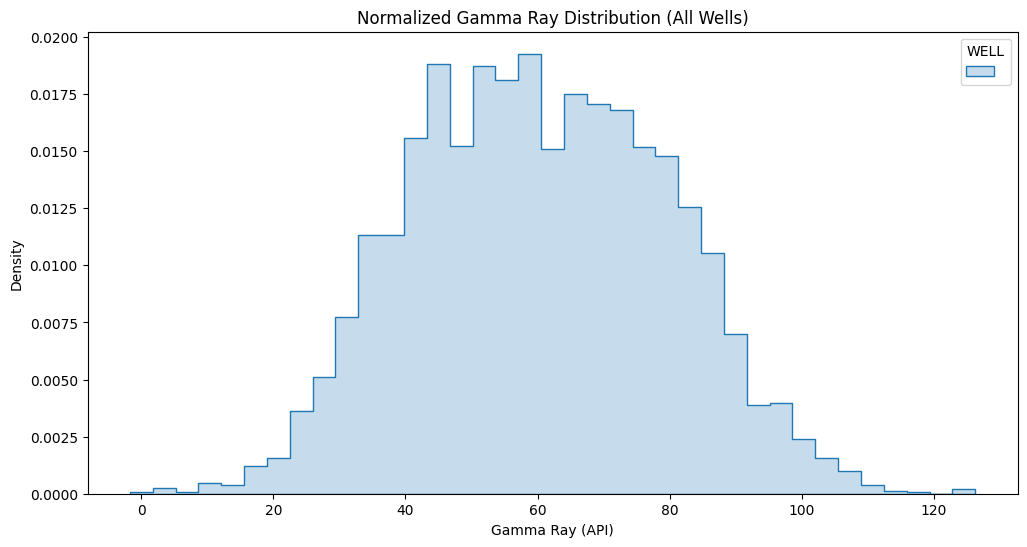

In [10]:
import seaborn as sns

plt.figure(figsize=(12, 6))

# The 'hue' parameter now finds 'WELL' because we reset the index above
sns.histplot(data=df, x='GR', hue='WELL', element="step", stat="density", common_norm=False)

plt.title('Normalized Gamma Ray Distribution (All Wells)')
plt.xlabel('Gamma Ray (API)')
plt.show()

### 6. Final Export
We now have a clean, normalized Pandas DataFrame. We can save this as a CSV for use in Scikit-Learn or TensorFlow.

In [11]:
output_csv = '..data/cleaned_bulk_data.csv'
df.to_csv(output_csv)
print(f"Cleaned data saved to {output_csv}")

Cleaned data saved to ../11_LAS_Processor/data/cleaned_bulk_data.csv


## 7. Curve Patching with Machine Learning

**Problem:** Real-world logs often have missing intervals (nulls) due to tool failure or poor borehole conditions. In our synthetic dataset, some wells have gaps in the Gamma Ray (GR) curve.

**Solution:** We can use **Supervised Learning** to patch these gaps. Since Gamma Ray (Lithology) often correlates with Neutron/Density (Porosity) in specific geological settings, we can train a regressor to predict GR based on NPHI and RHOB.

**Model:**
We will use a simple **Linear Regression** model:
$$GR_{pred} = \beta_0 + \beta_1(NPHI) + \beta_2(RHOB) + \epsilon$$

**Steps:**
1.  **Split Data:** Separate the dataset into "Training" (rows with complete data) and "Prediction" (rows where GR is missing but other curves exist).
2.  **Train:** Fit the model on the complete data.
3.  **Impute:** Predict values for the missing GR intervals.
4.  **Patch:** Fill the nulls in the original dataframe.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1. Define Features and Target
features = ['NPHI', 'RHOB']
target = 'GR'

# 2. Create Training Set (Drop rows where ANY key curve is missing)
train_df = df.dropna(subset=features + [target])

# 3. Create Prediction Set (Rows where Target is NaN, but Features are valid)
# We only want to patch rows where we have input data (NPHI/RHOB) to calculate from.
pred_df = df[df[target].isna() & df[features].notna().all(axis=1)]

print(f"Training Samples: {len(train_df)}")
print(f"Samples to Patch: {len(pred_df)}")

# 4. Train the Model
model = LinearRegression()
X_train = train_df[features]
y_train = train_df[target]

model.fit(X_train, y_train)

# Evaluate model quickly
r2 = r2_score(y_train, model.predict(X_train))
print(f"Model Training R2 Score: {r2:.4f}")
print(f"Equation: GR = {model.intercept_:.2f} + {model.coef_[0]:.2f}*NPHI + {model.coef_[1]:.2f}*RHOB")

0it [12:42, ?it/s]

Training Samples: 4152
Samples to Patch: 705
Model Training R2 Score: 0.0004
Equation: GR = 40.94 + 0.79*NPHI + 8.36*RHOB


### 8. Applying and Visualizing the Patch
Now that the model is trained, we will predict the missing values and merge them back into the main dataset. We will then visualize a specific well to see how the gaps were filled.

In [15]:
df.head()

,WELL,DEPT,GR,NPHI,RHOB,GR_PATCHED
0,,1000.0,58.8328900000,0.2254300000,2.3554100000,58.8328900000
1,,1001.0,64.0670217365,0.2628751098,2.3411884431,64.0670217365
2,,1002.0,87.7023743624,0.1686688252,2.4461481538,87.7023743624
3,,1003.0,60.6330742928,0.3499140447,2.2424616301,60.6330742928
4,,1004.0,80.2836568975,0.2364146119,2.3849107134,80.2836568975


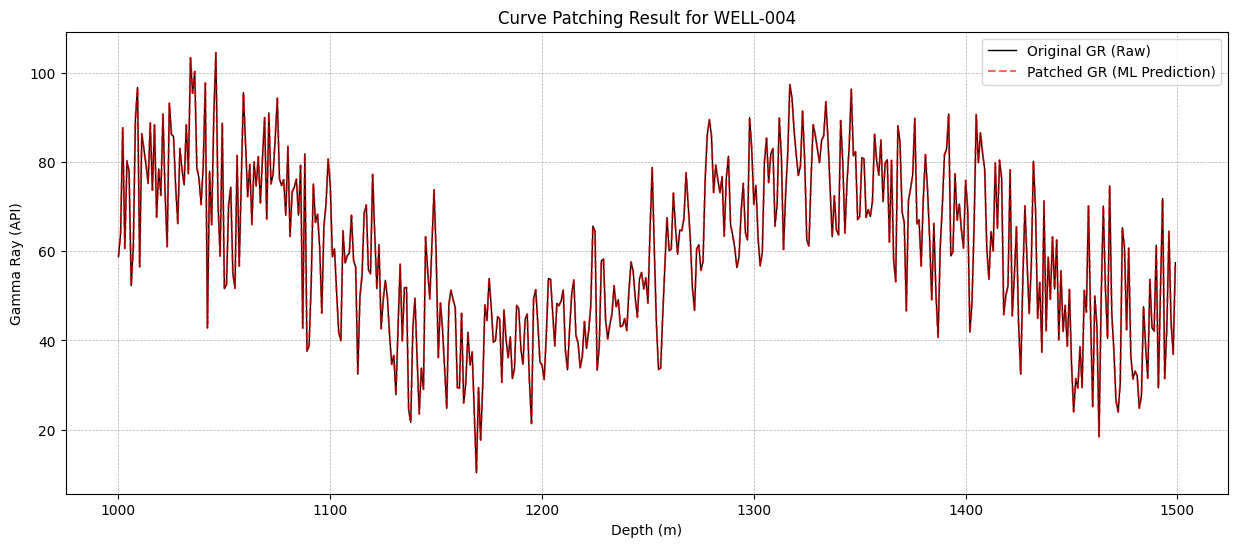

In [16]:
# 1. Predict missing values
X_pred = pred_df[features]
predicted_gr = model.predict(X_pred)

# 2. Assign predicted values to the original DataFrame
# We use the index of pred_df to ensure we map values to the exact correct rows
df.loc[pred_df.index, 'GR_PATCHED'] = predicted_gr

# Fill the rest of the column with original GR data where it wasn't missing
df['GR_PATCHED'] = df['GR_PATCHED'].fillna(df['GR'])

# 3. Visualization
# Let's find a well that had missing data (The generator script put gaps in wells where index % 3 == 0, e.g., Well-001 or Well-004)
# We will filter for a specific well to make the plot clear.
well_data = df.iloc[:500,:]

plt.figure(figsize=(15, 6))

# Plot Original Data (with gaps)
plt.plot(well_data['DEPT'], well_data['GR'], label='Original GR (Raw)', color='black', linewidth=1)

# Plot Patched Data (overlay)
# We plot this with a lower zorder or different style to show the "fill"
plt.plot(well_data['DEPT'], well_data['GR_PATCHED'], label='Patched GR (ML Prediction)', color='red', linestyle='--', alpha=0.6)

plt.title(f'Curve Patching Result for {target_well}')
plt.ylabel('Gamma Ray (API)')
plt.xlabel('Depth (m)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Highlight the patched area
plt.show()